## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [21]:
# (re-)load layers
%run modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

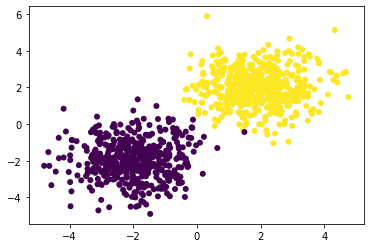

In [3]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [15]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then 

# net = Sequential()
# net.add(Linear(2, 4))
# net.add(ReLU())
# net.add(Linear(4, 2))
# net.add(LogSoftMax())

Linear 2 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [4]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [5]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

In [10]:
net = Sequential()
net.add(Linear(2, 4))
net.add(ReLU())
net.add(Linear(4, 2))
net.add(LogSoftMax())

In [11]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 1000

### Train

Basic training loop. Examine it.

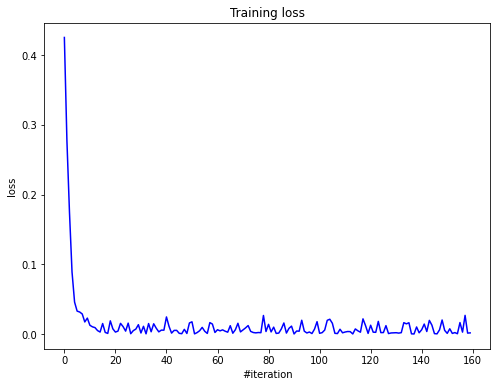

Current loss: 0.001841


In [9]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

batch_size 1000, wider network

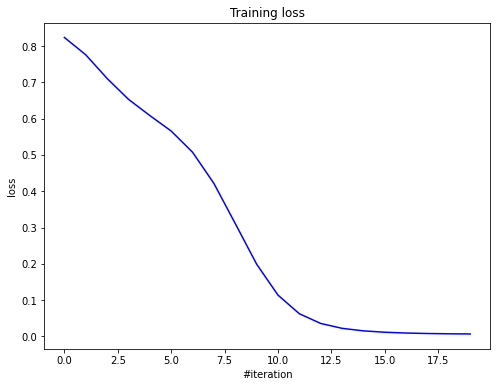

Current loss: 0.006857


In [12]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)  

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [51]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset(flatten=True)

In [52]:
print(X_train.shape)

(50000, 784)


In [53]:
print(X_test.shape)

(10000, 784)


One-hot encode the labels first.

In [ ]:
# Your code goes here. ################################################
n_labels = len(np.unique(y_train))
n_samples_tr = len(y_train)
n_samples_test = len(y_test)

y_train_encoded = np.zeros((n_samples_tr, n_labels))
for i in range(n_samples_tr):
    y_train_encoded[i, y_train[i]] = 1.0
y_train = y_train_encoded

#y_test_encoded = np.zeros((n_samples_test, n_labels))
#for i in range(n_samples_test):
    #y_test_encoded[i, y_test[i]] = 1.0
#y_test = y_test_encoded

print(y_train)
#print(y_test)

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

In [ ]:
# Your code goes here. ################################################

In [17]:
n_in = 784

net_elu = Sequential()
net_elu.add(Linear(n_in, int(n_in / 2)))
net_elu.add(ELU())
net_elu.add(Linear(int(n_in / 2), int(n_in / 4)))
net_elu.add(ELU())
net_elu.add(Linear(int(n_in / 4), n_labels))
net_elu.add(LogSoftMax())

net_relu = Sequential()
net_relu.add(Linear(n_in, int(n_in / 2)))
net_relu.add(ReLU())
net_relu.add(Linear(int(n_in / 2), int(n_in / 4)))
net_relu.add(ReLU())
net_relu.add(Linear(int(n_in / 4), n_labels))
net_relu.add(LogSoftMax())

net_leakyrelu = Sequential()
net_leakyrelu.add(Linear(n_in, int(n_in / 2)))
net_leakyrelu.add(LeakyReLU())
net_leakyrelu.add(Linear(int(n_in / 2), int(n_in / 4)))
net_leakyrelu.add(LeakyReLU())
net_leakyrelu.add(Linear(int(n_in / 4), n_labels))
net_leakyrelu.add(LogSoftMax())

net_softp = Sequential()
net_softp.add(Linear(n_in, int(n_in / 2)))
net_softp.add(SoftPlus())
net_softp.add(Linear(int(n_in / 2), int(n_in / 4)))
net_softp.add(SoftPlus())
net_softp.add(Linear(int(n_in / 4), n_labels))
net_softp.add(LogSoftMax())

In [94]:
net_elu_bn = Sequential()
net_elu_bn.add(Linear(n_in, int(n_in / 2)))
net_elu_bn.add(BatchNormalization())
net_elu_bn.add(ChannelwiseScaling(int(n_in / 2)))
net_elu_bn.add(ELU())
net_elu_bn.add(Linear(int(n_in / 2), int(n_in / 4)))
net_elu_bn.add(BatchNormalization())
net_elu_bn.add(ChannelwiseScaling(int(n_in / 4)))
net_elu_bn.add(ELU())
net_elu_bn.add(Linear(int(n_in / 4), n_labels))
net_elu_bn.add(LogSoftMax())

net_relu_bn = Sequential()
net_relu_bn.add(Linear(n_in, int(n_in / 2)))
net_relu_bn.add(BatchNormalization())
net_relu_bn.add(ChannelwiseScaling(int(n_in / 2)))
net_relu_bn.add(ReLU())
net_relu_bn.add(Linear(int(n_in / 2), int(n_in / 4)))
net_relu_bn.add(BatchNormalization())
net_relu_bn.add(ChannelwiseScaling(int(n_in / 4)))
net_relu_bn.add(ReLU())
net_relu_bn.add(Linear(int(n_in / 4), n_labels))
net_relu_bn.add(LogSoftMax())

net_leakyrelu_bn = Sequential()
net_leakyrelu_bn.add(Linear(n_in, int(n_in / 2)))
net_leakyrelu_bn.add(BatchNormalization())
net_leakyrelu_bn.add(ChannelwiseScaling(int(n_in / 2)))
net_leakyrelu_bn.add(LeakyReLU())
net_leakyrelu_bn.add(Linear(int(n_in / 2), int(n_in / 4)))
net_leakyrelu_bn.add(BatchNormalization())
net_leakyrelu_bn.add(ChannelwiseScaling(int(n_in / 4)))
net_leakyrelu_bn.add(LeakyReLU())
net_leakyrelu_bn.add(Linear(int(n_in / 4), n_labels))
net_leakyrelu_bn.add(LogSoftMax())

net_softp_bn = Sequential()
net_softp_bn.add(Linear(n_in, int(n_in / 2)))
net_softp_bn.add(BatchNormalization())
net_softp_bn.add(ChannelwiseScaling(int(n_in / 2)))
net_softp_bn.add(SoftPlus())
net_softp_bn.add(Linear(int(n_in / 2), int(n_in / 4)))
net_softp_bn.add(BatchNormalization())
net_softp_bn.add(ChannelwiseScaling(int(n_in / 4)))
net_softp_bn.add(SoftPlus())
net_softp_bn.add(Linear(int(n_in / 4), n_labels))
net_softp_bn.add(LogSoftMax())

In [95]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 5
batch_size = 1000

In [96]:
def train_loop(net, X_train, y_train):
    loss_history = []
    #net.train()

    for i in range(n_epoch):
        for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
            net.zeroGradParameters()
        
            # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)
    
            # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)
        
            # Update weights
            sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
            loss_history.append(loss)
    return(loss_history)

In [20]:
losses_relu = train_loop(net_relu, X_train, y_train)
losses_elu = train_loop(net_elu, X_train, y_train)
losses_leakyrelu = train_loop(net_leakyrelu, X_train, y_train)
losses_softp = train_loop(net_softp, X_train, y_train)

In [98]:
losses_relu_bn = train_loop(net_relu_bn, X_train, y_train)
losses_elu_bn = train_loop(net_elu_bn, X_train, y_train)
losses_leakyrelu_bn = train_loop(net_leakyrelu_bn, X_train, y_train)
losses_softp_bn = train_loop(net_softp_bn, X_train, y_train)

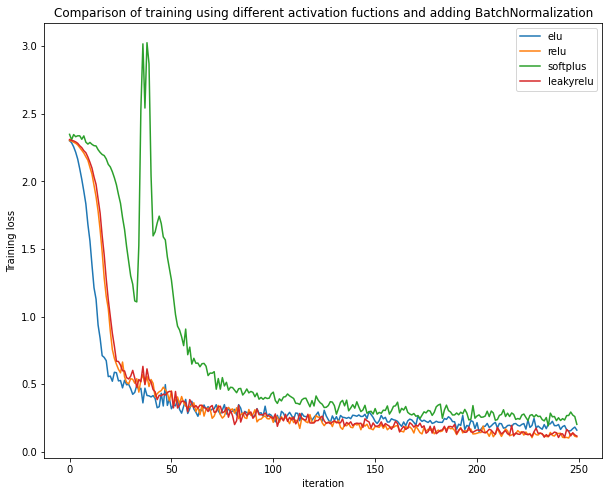

In [54]:
fig, ax = plt.subplots(figsize=(10, 8)) 
x = np.arange(len(losses_relu))
ax.plot(x, losses_elu, label="elu") 
ax.plot(x, losses_relu, label="relu") 
ax.plot(x, losses_softp, label="softplus") 
ax.plot(x, losses_leakyrelu, label="leakyrelu") 
ax.plot(x, losses_elu_bn, label="elu + batch_norm") 
ax.plot(x, losses_relu_bn, label="relu + batch_norm") 
ax.plot(x, losses_softp_bn, label="softplus + batch_norm") 
ax.plot(x, losses_leakyrelu_bn, label="leakyrelu + batch_norm")

ax.legend(loc = 'upper right')

plt.title("Comparison of training using different activation fuctions and adding BatchNormalization")
plt.xlabel("iteration")
plt.ylabel("Training loss")
plt.show() 

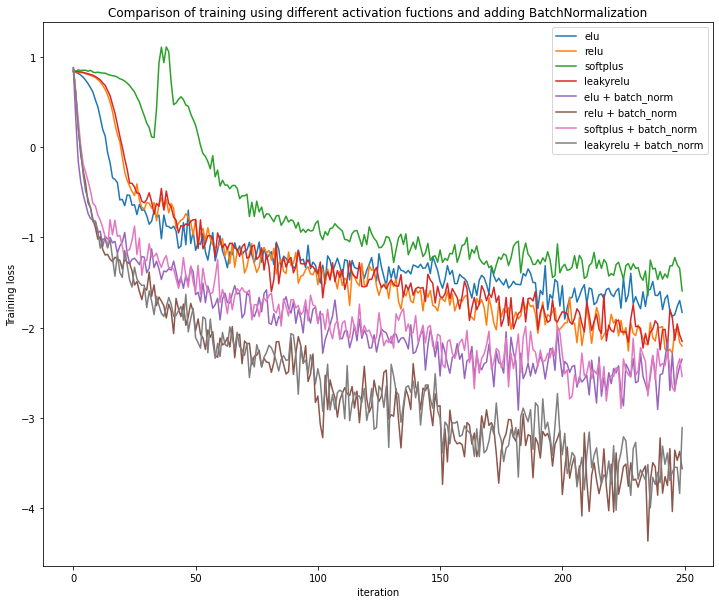

In [100]:
fig, ax = plt.subplots(figsize=(12, 10)) 
x = np.arange(len(losses_relu))
ax.plot(x, np.log(losses_elu), label="elu") 
ax.plot(x, np.log(losses_relu), label="relu") 
ax.plot(x, np.log(losses_softp), label="softplus") 
ax.plot(x, np.log(losses_leakyrelu), label="leakyrelu") 
ax.plot(x, np.log(losses_elu_bn), label="elu + batch_norm") 
ax.plot(x, np.log(losses_relu_bn), label="relu + batch_norm") 
ax.plot(x, np.log(losses_softp_bn), label="softplus + batch_norm") 
ax.plot(x, np.log(losses_leakyrelu_bn), label="leakyrelu + batch_norm")

ax.legend(loc = 'upper right')

plt.title("Comparison of training using different activation fuctions and adding BatchNormalization")
plt.xlabel("iteration")
plt.ylabel("Training loss")
plt.show() 

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

In [ ]:
# Your answer goes here. ################################################

По кривой обучения видно, что функции активации ReLU и LeakyReLU предпочтительнее остальных, так как при одинаковом кол-ве итераций лосс уменьшается сильнее, а также модели с этими функциями активации эффективнее по времени, так как не требуется вычисления экспоненты от входа в нелинейный слой. Добавление BatchNormalization улучшает обучение для всех моделей, различающихся только функциями активации.

In [101]:
net_relu_adam = Sequential()
net_relu_adam.add(Linear(n_in, int(n_in / 2)))
net_relu_adam.add(BatchNormalization())
net_relu_adam.add(ChannelwiseScaling(int(n_in / 2)))
net_relu_adam.add(ReLU())
net_relu_adam.add(Linear(int(n_in / 2), int(n_in / 4)))
net_relu_adam.add(BatchNormalization())
net_relu_adam.add(ChannelwiseScaling(int(n_in / 4)))
net_relu_adam.add(ReLU())
net_relu_adam.add(Linear(int(n_in / 4), n_labels))
net_relu_adam.add(LogSoftMax())

In [105]:
optimizer_config = {'learning_rate' : 1e-1, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-8}
optimizer_state = {}

# Looping params
n_epoch = 5
batch_size = 1000

In [106]:
def train_loop(net, X_train, y_train):
    loss_history = []
    #net.train()

    for i in range(n_epoch):
        for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
            net.zeroGradParameters()
        
            # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)
    
            # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)
        
            # Update weights
            adam_optimizer(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
            loss_history.append(loss)
    return(loss_history)

In [107]:
losses_relu_adam = train_loop(net_relu_adam, X_train, y_train)

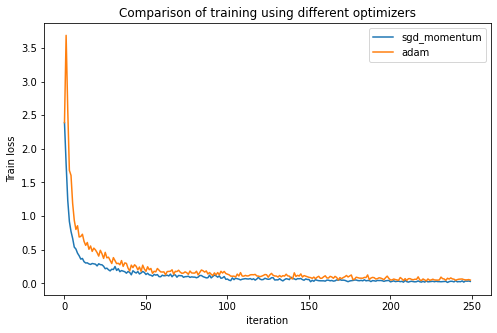

In [111]:
fig, ax = plt.subplots(figsize=(8, 5)) 
x = np.arange(len(losses_relu))
ax.plot(x, losses_relu_bn, label="sgd_momentum") 
ax.plot(x, losses_relu_adam, label="adam")

ax.legend(loc = 'upper right')

plt.title("Comparison of training using different optimizers")
plt.xlabel("iteration")
plt.ylabel("Train loss")
plt.show() 

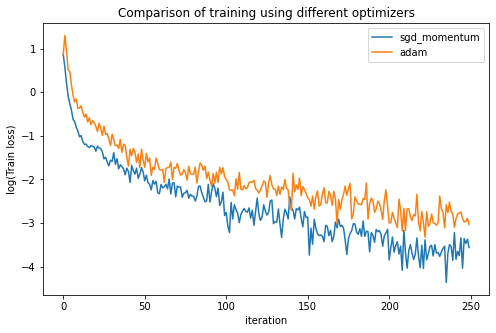

In [112]:
fig, ax = plt.subplots(figsize=(8, 5)) 
x = np.arange(len(losses_relu))
ax.plot(x, np.log(losses_relu_bn), label="sgd_momentum") 
ax.plot(x, np.log(losses_relu_adam), label="adam")

ax.legend(loc = 'upper right')

plt.title("Comparison of training using different optimizers")
plt.xlabel("iteration")
plt.ylabel("log(Train loss)")
plt.show() 

**SGD** optimizer with momentum performs **better**

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

Добавила слои, уменьшение lr в процессе обучения, использовала SGD и ReLU, которые лучше других оптимизаторов и функций активации показали себя и на этой архитектуре. Не стала добавлять аугментации, так как датасет и так достаточно большой для такой архитектуры и хватает тренировочных данных для хорошего обучения модели.

In [14]:
# Your code goes here. ################################################
n_in = 784
cool_net = Sequential()
cool_net.add(Linear(n_in, int(n_in * 2)))
cool_net.add(Dropout())
cool_net.add(ReLU())
cool_net.add(Linear(int(n_in * 2), int(n_in / 2)))
cool_net.add(Dropout())
cool_net.add(ReLU())
cool_net.add(Linear(int(n_in / 2), int(n_in / 8)))
cool_net.add(Dropout())
cool_net.add(ReLU())
cool_net.add(Linear(int(n_in / 8), n_labels))
cool_net.add(LogSoftMax())

In [30]:
def train_loop(net, X_train, y_train):
    loss_history = []
    #net.train()

    for i in range(n_epoch):
        iter = 0
        if (i // 3 == 0): 
            optimizer_config["learning_rate"] *= 0.1 #lr_decay
        for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
            net.zeroGradParameters()
        
            # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)
    
            # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)
        
            # Update weights
            sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
            iter += 1
            if (iter // 10 == 0):
                loss_history.append(loss)
        print(loss)
    return(loss_history)

In [45]:
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}
criterion = ClassNLLCriterion()
n_epoch = 5
batch_size = 512

In [ ]:
losses_dp = train_loop(cool_net, X_train, y_train)
print('Current loss: %f' % loss)  

In [44]:
n_in = 784
cool_net1 = Sequential()
cool_net1.add(Linear(n_in, int(n_in * 2)))
cool_net1.add(BatchNormalization())
cool_net1.add(ChannelwiseScaling(int(n_in * 2)))
cool_net1.add(ReLU())
cool_net1.add(Linear(int(n_in * 2), int(n_in / 2)))
cool_net1.add(BatchNormalization())
cool_net1.add(ChannelwiseScaling(int(n_in / 2)))
cool_net1.add(ReLU())
cool_net1.add(Linear(int(n_in / 2), int(n_in / 8)))
cool_net1.add(BatchNormalization())
cool_net1.add(ChannelwiseScaling(int(n_in / 8)))
cool_net1.add(ReLU())
cool_net1.add(Linear(int(n_in / 8), n_labels))
cool_net1.add(LogSoftMax())

0.19476339357649045
0.16511296588686206
0.1733836458989028
0.1287119533083843
0.11343524811131693


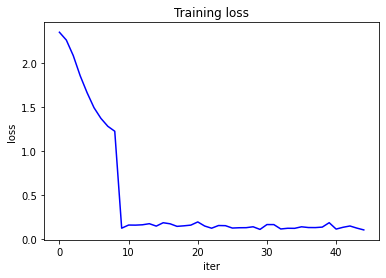

Current loss: 0.199619


In [46]:
losses_bn = train_loop(cool_net1, X_train, y_train)
plt.figure(figsize=(6, 4))
        
plt.title("Training loss")
plt.xlabel("iter")
plt.ylabel("loss")
plt.plot(losses_bn, 'b')
plt.show()
    
print('Current loss: %f' % loss)  

Print here your accuracy on test set. It should be around 90%.

In [37]:
from sklearn.metrics import accuracy_score

Accuracy for model using dropout

In [43]:
# Your answer goes here. ################################################
cool_net.evaluate()
predictions = cool_net.forward(X_test)
y_pred = np.argmax(predictions, axis=1)
print("Accuracy on test set: %f" % accuracy_score(y_pred, y_test))

Accuracy on test set: 0.941300


Accuracy for model using batch norm

In [48]:
cool_net1.evaluate()
predictions = cool_net1.forward(X_test)
y_pred = np.argmax(predictions, axis=1)
print("Accuracy on test set: %f" % accuracy_score(y_pred, y_test))

Accuracy on test set: 0.960200


In [49]:
cool_net1.__repr__()

'Linear 784 -> 1568\nBatchNormalization\nChannelwiseScaling\nReLU\nLinear 1568 -> 392\nBatchNormalization\nChannelwiseScaling\nReLU\nLinear 392 -> 98\nBatchNormalization\nChannelwiseScaling\nReLU\nLinear 98 -> 10\nLogSoftMax\n'

### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [ ]:
# Your beautiful code here.

In [63]:
import torch
from torch.utils.data import DataLoader, TensorDataset

In [66]:
from torch import nn

In [58]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset(flatten=True)

In [59]:
X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train)
X_val = torch.from_numpy(X_val)
y_val = torch.from_numpy(y_val)
X_test = torch.from_numpy(X_test) 
y_test = torch.from_numpy(y_test)

In [62]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
val_dataset = TensorDataset(X_val, y_val)

In [65]:
train_loader = DataLoader(train_dataset, batch_size=1000, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=1000, shuffle=False)

The same architecture as "cool_model" (reached the best test accuracy before)

In [99]:
n_in = 784
nice_model = nn.Sequential(
    nn.Linear(n_in, int(n_in * 2)),
    nn.BatchNorm1d(int(n_in * 2)),
    nn.ReLU(),
    nn.Linear(int(n_in * 2), int(n_in / 2)),
    nn.BatchNorm1d(int(n_in / 2)),
    nn.ReLU(),
    nn.Linear(int(n_in / 2), int(n_in / 8)),
    nn.BatchNorm1d(int(n_in / 8)),
    nn.ReLU(),
    nn.Linear(int(n_in / 8), 10),
    nn.LogSoftmax()
)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
nice_model.to(device, torch.float32)

Sequential(
  (0): Linear(in_features=784, out_features=1568, bias=True)
  (1): BatchNorm1d(1568, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Linear(in_features=1568, out_features=392, bias=True)
  (4): BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Linear(in_features=392, out_features=98, bias=True)
  (7): BatchNorm1d(98, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): Linear(in_features=98, out_features=10, bias=True)
  (10): LogSoftmax(dim=None)
)

In [100]:
def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs: int):
    train_loss = []
    val_loss = []
    val_accuracy = []
    
    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []

        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            # move data to target device
            ### YOUR CODE HERE
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            ### YOUR CODE HERE
            opt.zero_grad()
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            opt.step()
            ep_train_loss.append(loss.item())

        model.train(False) # disable dropout / use averages for batch_norm
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                # move data to target device
                ### YOUR CODE HERE
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                predictions = model(X_batch)
                loss = loss_fn(predictions, y_batch)
                # compute predictions
                ### YOUR CODE HERE
                ep_val_loss.append(loss.item())
                y_pred = np.argmax(predictions, axis=1)### YOUR CODE HERE
                ep_val_accuracy.append(torch.sum(y_pred==y_batch) / len(y_batch))

        # print the results for this epoch:

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))
        
        print(f"\t  training loss: {train_loss[-1]:.6f}")
        print(f"\tvalidation loss: {val_loss[-1]:.6f}")
        print(f"\tvalidation accuracy: {val_accuracy[-1]:.3f}")

    return train_loss, val_loss, val_accuracy

In [101]:
n_epochs = 30
opt = torch.optim.SGD(nice_model.parameters(), lr=1e-2, momentum=0.9)
loss_func = nn.CrossEntropyLoss()
train_loss, val_loss, val_accuracy = train_model(nice_model, train_loader, val_loader, loss_func, opt, n_epochs)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


	  training loss: 0.759374
	validation loss: 0.303844
	validation accuracy: 0.937
	  training loss: 0.208384
	validation loss: 0.157634
	validation accuracy: 0.962
	  training loss: 0.131776
	validation loss: 0.117879
	validation accuracy: 0.972
	  training loss: 0.092071
	validation loss: 0.097742
	validation accuracy: 0.975
	  training loss: 0.066443
	validation loss: 0.089080
	validation accuracy: 0.976
	  training loss: 0.049150
	validation loss: 0.080142
	validation accuracy: 0.979
	  training loss: 0.036385
	validation loss: 0.077197
	validation accuracy: 0.978
	  training loss: 0.026985
	validation loss: 0.072317
	validation accuracy: 0.980
	  training loss: 0.020531
	validation loss: 0.070427
	validation accuracy: 0.980
	  training loss: 0.015787
	validation loss: 0.068591
	validation accuracy: 0.981
	  training loss: 0.012620
	validation loss: 0.067797
	validation accuracy: 0.981
	  training loss: 0.010240
	validation loss: 0.066852
	validation accuracy: 0.981
	  training loss

Text(0.5, 0, 'epoch')

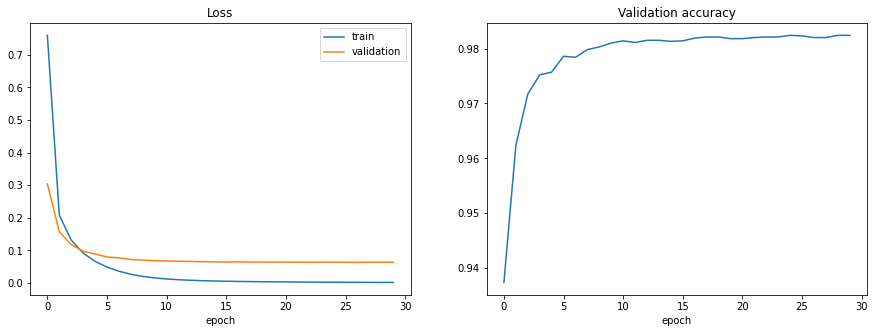

In [102]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].set_title('Loss')
axes[0].plot(train_loss, label='train')
axes[0].plot(val_loss, label='validation')
axes[0].set_xlabel('epoch')
axes[0].legend()

axes[1].set_title('Validation accuracy')
axes[1].plot(val_accuracy)
axes[1].set_xlabel('epoch')

In [103]:
def test_model(model, test_loader):
    accuracy = []
    model.train(False) # disable dropout / use averages for batch_norm
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            predictions = model(X_batch)
            y_pred = np.argmax(predictions, axis=1)
            accuracy.append(torch.sum(y_pred==y_batch) / len(y_batch))
    return np.mean(accuracy)

In [104]:
print("Test_accuracy = ", test_model(nice_model, test_loader))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Test_accuracy =  0.98260003


Accuracy on test data reached 0.98